# COGS 108 - EDA Checkpoint

# Names
- Alan Miyazaki
- Alex Guan
- Nathan Ahmann
- Renaldy Herlim

<a id='research_question'></a>
# Research Question

Does crime happen more or less frequently around police stations and can that knowledge be used to more effectively distribute police station locations?

# Setup

In [33]:
import pandas as pd
import datetime

# Data Cleaning

Describe your data cleaning steps here.

In [25]:
# Reading datasets from two different time periods

# https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
past_df = pd.read_csv("Crime_Data_from_2010_to_2019.csv", dtype = {"TIME OCC": str})
# https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
present_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", dtype = {"TIME OCC": str})

LAPD_df = pd.read_csv("LAPD_Police_Stations.csv")

# past dataset has column name typo
past_df = past_df.rename(columns={"AREA ": "AREA"})

# Both datasets use the same columns 
df = pd.concat([past_df, present_df])

In [26]:
# Dropping code columns since these are internal use and we don't get much 
# value from them given we have their description in a seperate column
df = df.drop(columns=[
    "Crm Cd", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", 
    "Crm Cd 4", "Premis Cd", "Weapon Used Cd", 
    "Mocodes", "Part 1-2", "Status", "Date Rptd"
    ])

# Changed code to be readable description
df["Vict Descent"] = df["Vict Descent"].replace({
                            "A": "Other Asian", 
                            "B": "Black", 
                            "C": "Chinese", 
                            "D": "Cambodian", 
                            "F": "Filipino", 
                            "G": "Guamanian", 
                            "H": "Hispanic/Latin/Mexican", 
                            "I": "American Indian/Alaskan Native", 
                            "J": "Japanese", 
                            "K": "Korean", 
                            "L": "Laotian", 
                            "O": "Other", 
                            "P": "Pacific Islander", 
                            "S": "Samoan", 
                            "U": "Hawaiian", 
                            "V": "Vietnamese", 
                            "W": "White", 
                            "X": "Unknown", 
                            "Z": "Asian Indian",
                        })

# Renamed X,Y to Longitude, Latitude
LAPD_df = LAPD_df.rename(columns={
    "X": "Longitude", 
    "Y": "Latitude"
    })

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [27]:
df.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/12/2010 12:00:00 AM,0045,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,0150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


One thing that we would be interested in knowing is if there is an equal distribution of crimes between police stations. From this we can see that there is a difference between how many cases each station has handled. This could either mean that some police stations are responsible for a larger area or there are more crimes happening in the areas those stations are covering. 

<AxesSubplot: >

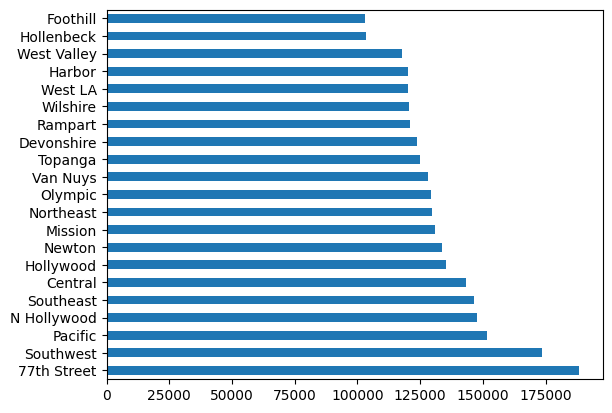

In [28]:
df["AREA NAME"].value_counts().plot(kind="barh")

In [14]:
df["Crm Cd Desc"].unique()

array(['VIOLATION OF COURT ORDER',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'OTHER MISCELLANEOUS CRIME', 'RAPE, ATTEMPTED',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'BURGLARY FROM VEHICLE',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BATTERY - SIMPLE ASSAULT', 'ROBBERY', 'BOMB SCARE',
       'CHILD NEGLECT (SEE 300 W.I.C.)',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'ATTEMPTED ROBBERY',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'BURGLARY', 'ARSON',
       'RAPE, FORCIBLE', 'BRANDISH WEAPON',
       'THROWING OBJECT AT MOVING VEHICLE',
       'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
       'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
       'SHOTS FIRED AT INHABITED DWELLING', 'VEHICLE - STOLEN',
    

In [31]:
df["TIME OCC"].value_counts()

1200    140328
1800     80333
2000     75077
1700     72212
1900     70800
         ...  
0543        30
0534        30
0431        25
0531        22
0551        19
Name: TIME OCC, Length: 1439, dtype: int64

This is to see when do most crimes happen. From this we can see that the most common hour for a crime to occur over the past 13 years was at noon. The least common time for a crime to occur was at 5 am. However this is a massive spike at 12 which is odd. A reason for this could be that the dataset only counts crimes reported which means that since it is noon, more people are out and can see/report on a crime. In contrast, people are sleeping at night so there are less people reporting crimes. Another reason for this could be that when a crime happens, they are more focused on the criminal instead of what time it is so when they make a report to an officer, they may choose noon due to it being daylight.

<AxesSubplot: >

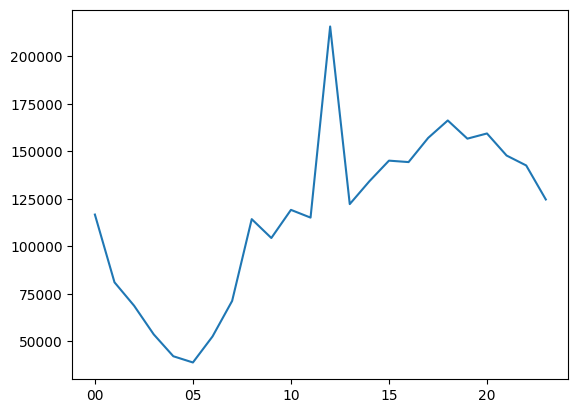

In [38]:
df["TIME OCC"].str[:2].value_counts().sort_index().plot()

In [39]:
df["TIME OCC"].str[:2].value_counts()

12    215755
18    166250
20    159399
17    157063
19    156668
21    147778
15    145084
16    144327
22    142552
14    134207
23    124631
13    122193
10    119154
00    116679
11    115077
08    114270
09    104337
01     80999
07     71185
02     68666
03     53586
06     52477
04     42056
05     38771
Name: TIME OCC, dtype: int64

In [40]:
df["TIME OCC"].value_counts()

1200    140328
1800     80333
2000     75077
1700     72212
1900     70800
         ...  
0543        30
0534        30
0431        25
0531        22
0551        19
Name: TIME OCC, Length: 1439, dtype: int64

In [45]:
df["DATE OCC"].value_counts().sort_index()

01/01/2010 12:00:00 AM    2311
01/01/2011 12:00:00 AM    2248
01/01/2012 12:00:00 AM    1859
01/01/2013 12:00:00 AM    1695
01/01/2014 12:00:00 AM    1597
                          ... 
12/31/2018 12:00:00 AM     607
12/31/2019 12:00:00 AM     554
12/31/2020 12:00:00 AM     572
12/31/2021 12:00:00 AM     570
12/31/2022 12:00:00 AM     553
Name: DATE OCC, Length: 4806, dtype: int64

<AxesSubplot: >

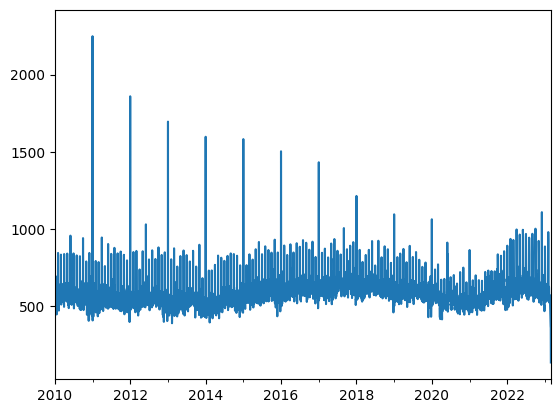

In [51]:
pd.to_datetime(df["DATE OCC"]).value_counts().sort_index().plot()

Seems like there are more crimes happening during new years?

In [52]:
pd.to_datetime(df["DATE OCC"]).value_counts()

2010-01-01    2311
2011-01-01    2248
2012-01-01    1859
2013-01-01    1695
2014-01-01    1597
              ... 
2014-02-09     395
2013-02-09     390
2023-02-25     368
2023-02-26     360
2023-02-27     136
Name: DATE OCC, Length: 4806, dtype: int64

Number of crimes reported plotted by month and year

<AxesSubplot: >

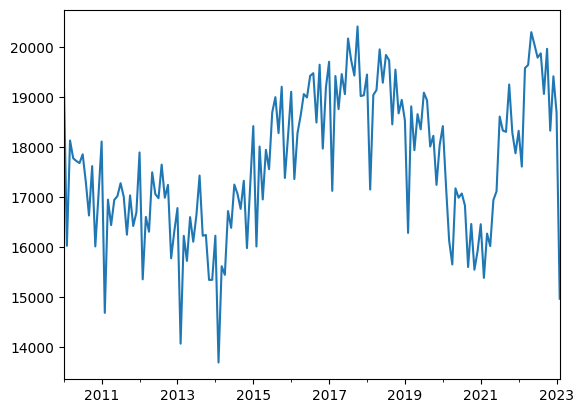

In [57]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('M').value_counts().sort_index().plot()

In [58]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('M').value_counts()

2017-10    20410
2022-05    20297
2017-07    20169
2022-06    20048
2022-10    19963
           ...  
2013-11    15340
2023-02    14963
2011-02    14681
2013-02    14065
2014-02    13688
Freq: M, Name: DATE OCC, Length: 158, dtype: int64

This is number of crims reported over years. 2023 is extremely low because the year is going on.

<AxesSubplot: >

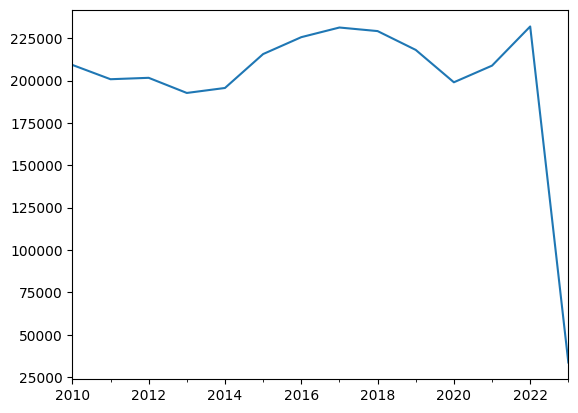

In [59]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('Y').value_counts().sort_index().plot()

In [60]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('Y').value_counts()

2022    231916
2017    231303
2018    229197
2016    225609
2019    218088
2015    215641
2010    209229
2021    208810
2012    201621
2011    200792
2020    198988
2014    195628
2013    192689
2023     33653
Freq: A-DEC, Name: DATE OCC, dtype: int64

Removing 2023 to get a better graph. We can see some oddities. 2013, 2014, and 2020 are low in comparison to other years. 2020 is likely due to the pandemic since everyone was encouraged to stay at home which leads to less crimes reported (and maybe less crimes happening?). I have no idea of any reason to explain why 2013 and 2014 are so low. In addition its a bit weird that crime starts picking to make a curve at 2017. Also a massive spite at 2022 as well but not too sure of the reason there. 

<AxesSubplot: >

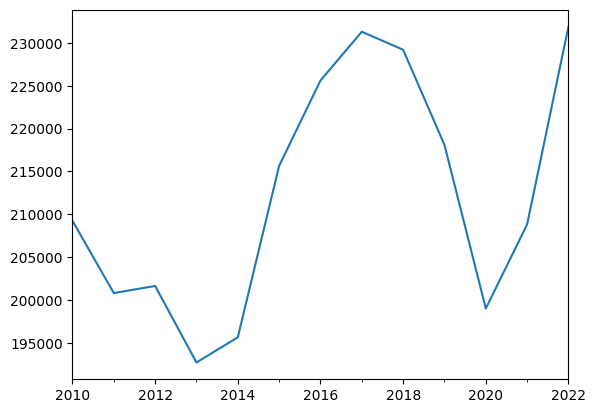

In [61]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('Y').value_counts().sort_index()[:-1].plot()

In [6]:
LAPD_df

,Longitude,Latitude,OBJECTID,DIVISION,LOCATION,PREC
0,-118.289242,33.757661,1,HARBOR,2175 JOHN S. GIBSON BLVD.,5
1,-118.275394,33.938627,2,SOUTHEAST,145 W. 108TH ST.,18
2,-118.277670,33.970307,3,77TH STREET,7600 S. BROADWAY,12
3,-118.419842,33.991655,4,PACIFIC,12312 CULVER BLVD.,14
4,-118.305142,34.010575,5,SOUTHWEST,1546 MARTIN LUTHER KING JR. BLVD.,3
5,-118.256119,34.012356,6,NEWTON,3400 S. CENTRAL AVE.,13
6,-118.247294,34.044019,7,CENTRAL,251 E. 6TH ST.,1
7,-118.450780,34.043777,8,WEST LOS ANGELES,1663 BUTLER AVE.,8
8,-118.213068,34.045009,9,HOLLENBECK,2111 E. 1ST ST.,4
9,-118.342830,34.046748,10,WILSHIRE,4861 VENICE BLVD.,7
